In [1]:
import numpy as np
from numpy.random import permutation
import os
import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import pickle
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.regularizers import l2 
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.models import Sequential
from keras.models import load_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
%matplotlib inline
print(os.listdir())

['.ipynb_checkpoints', 'BaseLine_Model_DriverActivity.zip', 'checkpoint', 'DriverActivityLog.zip', 'DriverActivityLog_bl', 'DriverActivityLog_v2', 'DriverActivityLog_v2.zip', 'Driver_Activity_BaseLine_Keras_to_TF.ipynb', 'Driver_Activity_BaseLine_Model.ipynb', 'Driver_Activity_BaseLine_Model_TensorFlow.ipynb', 'Driver_Activity_Petrained_Keras_to_TF.ipynb', 'driver_imgs_list.csv', 'imgs.zip', 'img_1.jpg', 'img_150.jpg', 'img_2.jpg', 'img_80.jpg', 'model_bl.h5', 'model_bl.pb', 'model_v2.h5', 'Output', 'sample_submission.csv', 'sample_test_data.zip', 'state-farm-distracted-driver-detection.zip', 'Support Tools', 'temp', 'test', 'train', 'training_1', 'Untitled.ipynb']


In [3]:
img_cols=224
img_rows=224

In [4]:
df= pd.read_csv('driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [5]:
def load_images(path, rows=None, cols=None, gray=False):
    img= cv2.imread(path, 0)
    if rows!= None and cols!= None:
        img= cv2.resize(img, (rows, cols))
    return img

In [6]:
paths= glob.glob(os.path.join("./train", "*", "*.jpg"))

In [7]:
def load_data(split=0.33, rows=None, cols=None):
    paths = glob.glob(os.path.join("./train", "*",  "*.jpg"))
    if rows != None and cols != None:
        images = [load_images(x, rows, cols,gray=False) for x in paths]
    else:
        images = [load_image(x, gray=False) for x in paths]
    return np.array(images)

In [8]:
#Load Data

X= load_data(rows=img_rows, cols=img_cols)

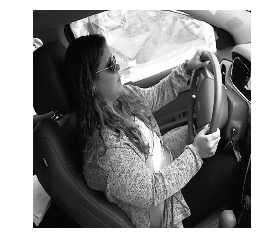

In [9]:
#Plot Sample Data
plt.imshow(X[119], cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# Import Labels

#read folder name and capture the category
labels=[x.split('\\')[1] for x in paths]
#print(labels)

#Convert to DF to perform operations
labels_df= pd.DataFrame(labels)
labels_df.columns=['label']

#Create a dictionary for feature engineering
value_dict={'c0': 0, 'c1': 1, 'c2': 2, 'c3':3, 'c4':4, 'c5':5, 'c6':6, 'c7':7, 'c8':8, 'c9':9}

#Create a function for replacement
def map_values(row, value_dict):
    return value_dict[row]

labels_df['category'] = labels_df['label'].apply(map_values, args=(value_dict,))
print(labels_df.head())

#create the label for training and testing
y= np.array(labels_df['category'])

  label  category
0    c0         0
1    c0         0
2    c0         0
3    c0         0
4    c0         0


In [11]:
#Create train and test data

print(X.shape)
print(y.shape)

(22424, 224, 224)
(22424,)


In [12]:
shuffle_index= permutation(len(X))
X, y= X[shuffle_index], y[shuffle_index]
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.1, random_state=123)

In [13]:
X_train= X_train.astype('float32').reshape((-1,224,224,1))/255.
X_val= X_val.astype('float32').reshape((-1,224,224,1))/255.

# Convert labels to categorical

y_train= to_categorical(y_train)
y_val= to_categorical(y_val)
X_train.shape

(20181, 224, 224, 1)

In [16]:
# Build model

In [33]:
# First Base-Line Model

model_bl= Sequential()
model_bl.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer= l2(0.001), input_shape=(224, 224,1)))
model_bl.add(MaxPooling2D((2,2)))
model_bl.add(Conv2D(64, (3,3), kernel_regularizer= l2(0.001), activation='relu'))
model_bl.add(MaxPooling2D((2,2)))
model_bl.add(Conv2D(32, (3,3), kernel_regularizer= l2(0.001), activation='relu'))
model_bl.add(Flatten())
model_bl.add(Dense(32, activation='relu'))
model_bl.add(Dense(10, activation='softmax'))

In [34]:
model_bl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 128)     1280      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 32)        18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2768928   
__________

In [35]:
model_bl.compile(optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True), 
                 loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history= model_bl.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_val, y_val), verbose=1)

Train on 20181 samples, validate on 2243 samples
Epoch 1/15
20181/20181 [==============================] - 362s 18ms/step - loss: 0.4971 - acc: 0.8445 - val_loss: 0.1064 - val_acc: 0.9777
Epoch 2/15
20181/20181 [==============================] - 373s 18ms/step - loss: 0.0610 - acc: 0.9895 - val_loss: 0.0631 - val_acc: 0.9884
Epoch 3/15
20181/20181 [==============================] - 373s 18ms/step - loss: 0.0342 - acc: 0.9950 - val_loss: 0.0455 - val_acc: 0.9920
Epoch 4/15
20181/20181 [==============================] - 376s 19ms/step - loss: 0.0180 - acc: 0.9993 - val_loss: 0.0375 - val_acc: 0.9960
Epoch 5/15
20181/20181 [==============================] - 380s 19ms/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9955
Epoch 6/15
20181/20181 [==============================] - 380s 19ms/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9964
Epoch 7/15
20181/20181 [==============================] - 380s 19ms/step - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0

In [8]:
# Save Model
#model_bl.save('model_v2.h5')  # creates a HDF5 file 'my_model.h5'


model = load_model('model_v2.h5')

In [19]:
train_acc= history.history['acc']
val_acc= history.history['val_acc']

train_loss= history.history['loss']
val_loss= history.history['val_loss']

epoch= range(1, len(train_loss)+1)

NameError: name 'history' is not defined

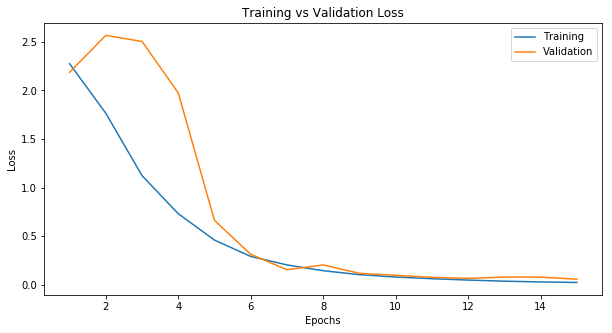

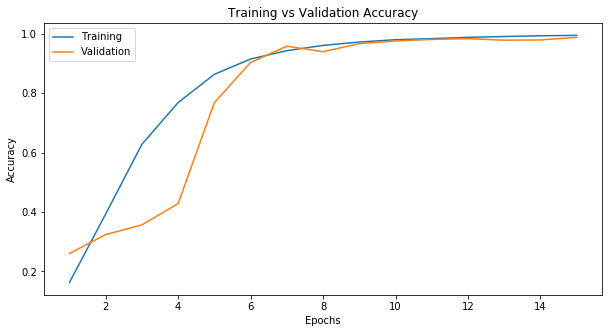

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(epoch, train_loss, label='Training')
plt.plot(epoch, val_loss, label='Validation')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch, train_acc, label='Training')
plt.plot(epoch, val_acc, label='Validation')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
model.evaluate(X_val, y_val)

2243/2243 [==============================] - 9s 4ms/step


[0.006992921530469634, 0.9991083370485956]

### The 10 classes to predict are: <br/><br/>

#### c0: safe driving                 - 0 <br/>
#### c1: texting - right              - 1<br/>
#### c2: talking on the phone - right - 2<br/>
#### c3: texting - left               - 3<br/>
#### c4: talking on the phone - left  - 4<br/>
#### c5: operating the radio          - 5<br/>
#### c6: drinking                     - 6<br/>
#### c7: reaching behind              - 7<br/>
#### c8: hair and makeup              - 8<br/>
#### c9: talking to passenger         - 9<br/>

In [15]:
img_to_b_predicited=X_val[[600]]
activity=model.predict(img_to_b_predicited)

activity_processed= np.round(activity, 3)
activity_processed.shape

(1, 10)

In [9]:
activity_name= np.array(['safe driving', 'texting - right', 'talking on the phone - right', 
                'texting - left', 'talking on the phone - left', 'operating the radio', 
                'drinking', 'reaching behind', 'hair and makeup','talking to passenger']).reshape(1,10)
activity_name.shape

(1, 10)

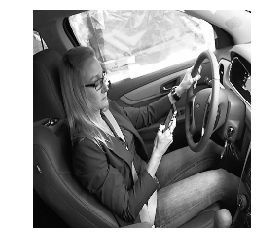

['safe driving'] : [0.]
['texting - right'] : [1.]
['talking on the phone - right'] : [0.]
['texting - left'] : [0.]
['talking on the phone - left'] : [0.]
['operating the radio'] : [0.]
['drinking'] : [0.]
['reaching behind'] : [0.]
['hair and makeup'] : [0.]
['talking to passenger'] : [0.]


In [17]:
plt.imshow(img_to_b_predicited.reshape(224, 224), cmap='gray')
plt.axis('off')
plt.show()
for i in range(0, 10):
    print(activity_name[:, i], ':', activity_processed[:, i])

In [19]:
# Save keras model to Tensorflow pb file and use tensorflow to reload the model and inference by the model

In [20]:
wkdir='./DriverActivityLog_v2'
pb_file_name= 'driver_model_v2.pb'

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph= session.graph
    with graph.as_default():
        freeze_var_names= list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names= output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def= graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device=''
            frozen_graph=convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
            return frozen_graph

In [21]:
frozen_graph= freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, wkdir, pb_file_name, as_text=False)

INFO:tensorflow:Froze 45 variables.
Converted 45 variables to const ops.


'./DriverActivityLog_v2\\driver_model_v2.pb'

In [22]:
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    with gfile.FastGFile(wkdir+'/'+pb_file_name, 'rb') as f:
        graph_def=tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in= tf.import_graph_def(graph_def)

In [23]:
writer= tf.summary.FileWriter(wkdir+'/log/')
writer.add_graph(sess.graph)
writer.flush()
writer.close()

In [25]:
saver=tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    save_path= saver.save(sess, './DriverActivityLog_v2/driver_model_v2.ckpt')

In [64]:
for op in sess.graph.get_operations():
    print(op)
    
tensor_output= sess.graph.get_tensor_by_name('import/dense_8/Softmax:0')
tensor_input= sess.graph.get_tensor_by_name('import/conv2d_10_input:0')
with tf.Session() as sess:
    predictions= sess.run(tensor_output, {tensor_input:X_val[[600]]})
    print(predictions)
    print(y_val[[500]])

name: "conv2d_10_input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 224
      }
      dim {
        size: 224
      }
      dim {
        size: 1
      }
    }
  }
}

name: "conv2d_10/random_uniform/shape"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 4
        }
      }
      tensor_content: "\003\000\000\000\003\000\000\000\001\000\000\000\200\000\000\000"
    }
  }
}

name: "conv2d_10/random_uniform/min"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_FLOAT
      tensor_shape {
      }
      float_val: -0.0718885138630867
    }
  }
}

name: "conv2d_10/random_uniform/max"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_F

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[4.1805230e-08 1.7695167e-12 6.2164396e-08 3.7335714e-11 9.0189128e-10
  2.0195215e-07 9.9999952e-01 4.5337707e-08 1.5810386e-07 1.7811229e-10]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


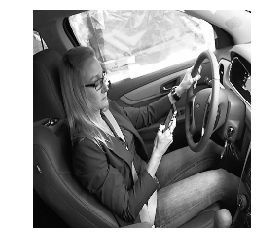

NameError: name 'predictions' is not defined

In [18]:
plt.imshow(img_to_b_predicited.reshape(224, 224), cmap='gray')
plt.axis('off')
plt.show()
for i in range(0, 10):
    print(activity_name[:, i], ':', activity_processed[:, i], ' : ', np.around(predictions[:,i]))

In [19]:
y_val[[600]]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [42]:
#TEST

import cv2
img=cv2.imread('C:/Users/soumyama/Documents/Python Scripts/Kaggle/DriverDistraction/test/img_1250.jpg', 0)
#img_78.jpg
#img_106.jpg
#img_110.jpg
#img_117.jpg
#img_675.jpg
#img_851.jpg
#img_1250.jpg

In [43]:
img.shape

(480, 640)

In [44]:
res_img= cv2.resize(img, (224,224))
#cv2.imshow('image',res_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

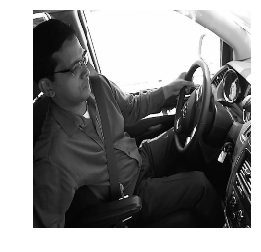

['safe driving'] : [0.]
['texting - right'] : [0.]
['talking on the phone - right'] : [0.]
['texting - left'] : [0.]
['talking on the phone - left'] : [0.]
['operating the radio'] : [0.]
['drinking'] : [0.]
['reaching behind'] : [0.995]
['hair and makeup'] : [0.004]
['talking to passenger'] : [0.001]


In [45]:
test_img= res_img.astype('float32').reshape((-1,224,224,1))/255.
test_activity=model.predict(test_img)
test_activity_processed= np.round(test_activity, 3)
plt.imshow(test_img.reshape(224, 224), cmap='gray')
plt.axis('off')
plt.show()
for i in range(0, 10):
    print(activity_name[:, i], ':', test_activity_processed[:, i])